<a href="https://colab.research.google.com/github/vmprakash-swaminathan/NAN-MUDHALVAN-ORACLE/blob/main/Neural_Network_with_Bayesian_Optimization_for_Customer_Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Network with Bayesian Optimization for Customer Churn Prediction

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner import BayesianOptimization

In [ ]:
data_path = './enhanced_feature_data.csv'
df = pd.read_csv(data_path)
df.drop(['tenure_bins'], axis=1, inplace=True)

feature_columns = [col for col in df.columns if col != 'Churn']
X = df[feature_columns]
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
def build_model(hp):
    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu'),
        Dropout(hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='bayesian_optimization',
    project_name='churn_model'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train, y_train, epochs=30, validation_split=0.2, callbacks=[early_stopping], verbose=2)

best_hps = tuner.get_best_hyperparameters()[0]

model = tuner.hypermodel.build(best_hps)

history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=2)

Trial 10 Complete [00h 00m 20s]
val_accuracy: 0.8078970909118652

Best val_accuracy So Far: 0.8118899762630463
Total elapsed time: 00h 03m 49s
Epoch 1/50
141/141 - 2s - 14ms/step - accuracy: 0.7799 - loss: 0.4610 - val_accuracy: 0.7977 - val_loss: 0.4156
Epoch 2/50
141/141 - 1s - 8ms/step - accuracy: 0.8045 - loss: 0.4211 - val_accuracy: 0.8075 - val_loss: 0.4060
Epoch 3/50
141/141 - 1s - 9ms/step - accuracy: 0.8052 - loss: 0.4151 - val_accuracy: 0.8092 - val_loss: 0.4057
Epoch 4/50
141/141 - 1s - 4ms/step - accuracy: 0.8063 - loss: 0.4114 - val_accuracy: 0.8057 - val_loss: 0.4072
Epoch 5/50
141/141 - 1s - 5ms/step - accuracy: 0.8107 - loss: 0.4091 - val_accuracy: 0.8012 - val_loss: 0.4048
Epoch 6/50
141/141 - 1s - 4ms/step - accuracy: 0.8116 - loss: 0.4035 - val_accuracy: 0.8004 - val_loss: 0.4069
Epoch 7/50
141/141 - 1s - 4ms/step - accuracy: 0.8112 - loss: 0.4078 - val_accuracy: 0.7995 - val_loss: 0.4077
Epoch 8/50
141/141 - 1s - 9ms/step - accuracy: 0.8107 - loss: 0.4000 - val_accu

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy: 0.80
Precision: 0.66
Recall: 0.51
F1-Score: 0.58
ROC AUC: 0.83


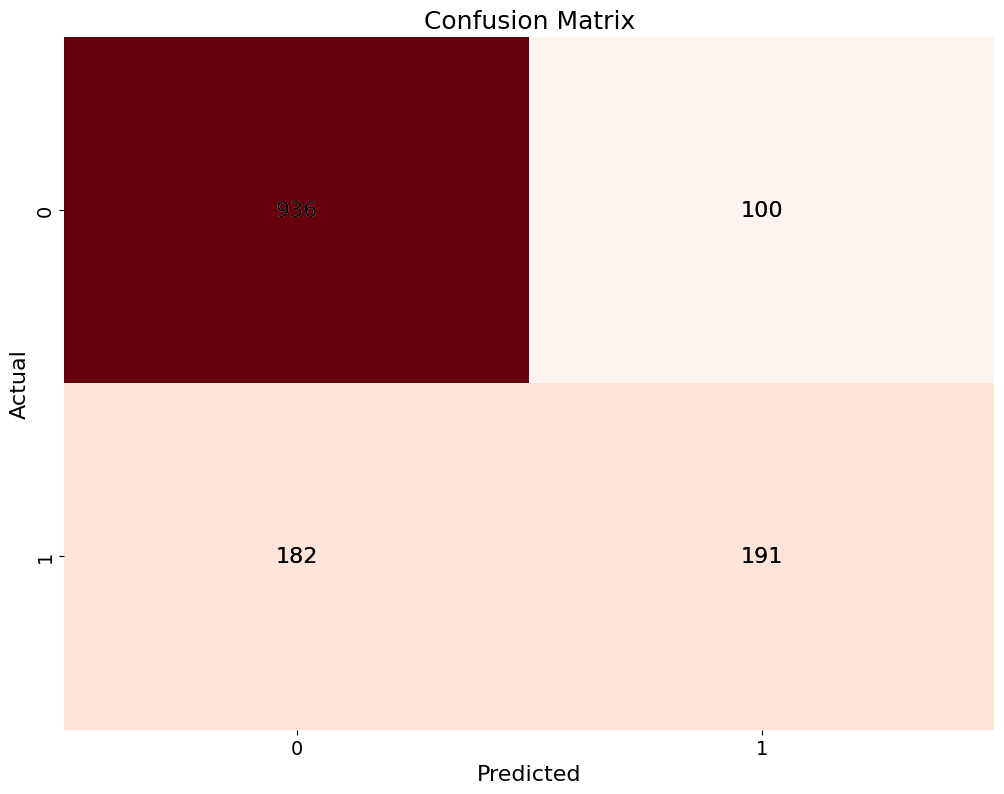

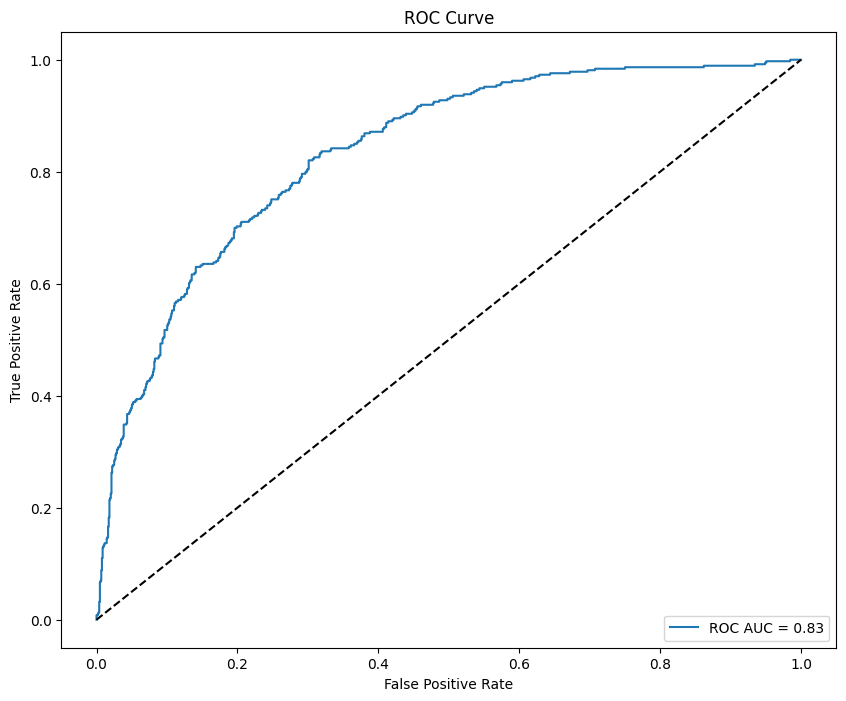

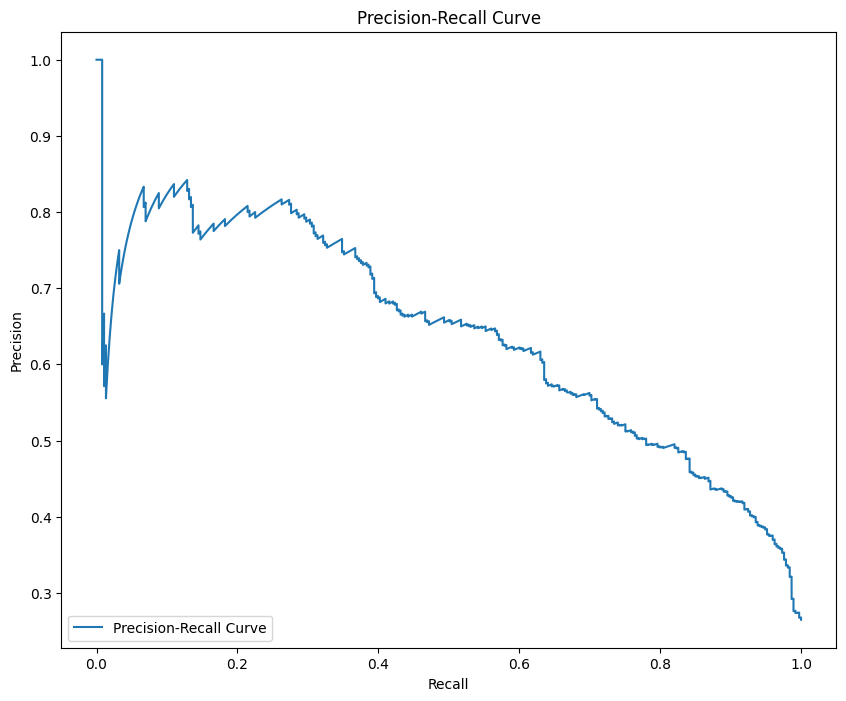

In [ ]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(10, 8))
plt.plot(recall_vals, precision_vals, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [ ]:
with open('./nn_bayes_evaluation_metrics.txt', 'w') as f:
    f.write(f'Accuracy: {accuracy:.2f}\n')
    f.write(f'Precision: {precision:.2f}\n')
    f.write(f'Recall: {recall:.2f}\n')
    f.write(f'F1-Score: {f1:.2f}\n')
    f.write(f'ROC AUC: {roc_auc:.2f}\n')

class_report = classification_report(y_test, y_pred)
with open('./nn_bayes_classification_report.txt', 'w') as f:
    f.write(class_report)

plt.figure(figsize=(12, 9))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', cbar=False, annot_kws={"size": 16})
plt.title('Confusion Matrix', fontsize=18)
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j + 0.5, i + 0.5, format(conf_matrix[i, j], 'd'),
                 ha="center", va="center", color="black", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig('./NN_bayes_ConfusionMatrix.png')
plt.close()

In [ ]:
model_filename = 'NN_bayes_churn_model_optimized.keras'
model.save(model_filename)
print(f'Model saved to {model_filename}')

Model saved to NN_bayes_churn_model_optimized.keras
